# Earthquake Watch

Three tasks:
1. All earthquakes globally above M 4.5 in the last week;
2. All earthquakes catalogued by GeoNet in the last week;
3. Something cool!

---
## Global Earthquakes

We will get these from IRIS.

In [1]:
%matplotlib inline

In [2]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np

from gphs445_utilities.animator import _blank_map

In [3]:
client = Client("IRIS")
cat = client.get_events(minmagnitude=4.5, starttime=UTCDateTime.now() - 7 * 86400)
print(cat)

121 Event(s) in Catalog:
2025-07-03T22:42:57.077000Z | -20.674,  -66.702 | 4.6  mb
2025-07-03T21:09:15.703000Z | +46.782, +151.344 | 4.9  Mww
...
2025-06-26T23:56:02.894000Z | +36.555, +140.389 | 4.6  mb
2025-06-26T23:53:54.448000Z | -20.560, -178.788 | 4.7  mb
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [4]:
def plot_catalog(catalog):
    lats, lons, depths, magnitudes, times = [], [], [], [], []
    for eq in catalog:
        try:
            ori = eq.preferred_origin() or eq.origins[-1]
        except IndexError:
            continue
        lats.append(ori.latitude)
        lons.append(ori.longitude)
        depths.append(ori.depth)
        times.append(ori.time)
        try:
            mag = eq.preferred_magnitude() or eq.magnitudes[-1]
        except IndexError:
            mag = None
        if mag:
            magnitudes.append(mag.mag)
        else:
            magnitudes.append(0.0)
    lats = np.array(lats)
    lons = np.array(lons)
    depths = np.array(depths) / 1000.0
    magnitudes = np.array(magnitudes)
    
    # sort by depth
    order = depths.argsort()
    order = order[::-1]
    lats = lats[order]
    lons = lons[order]
    depths = depths[order]
    magnitudes = magnitudes[order]
    
    norm = Normalize(vmin=min(depths), vmax=max(depths))
    cmap = plt.get_cmap("plasma_r")
    
    lat_range = lats.max() - lats.min()
    lon_range = lons.max() - lons.min()
    
    if lat_range > 30 and lon_range > 30:
        projection = "global"
        resolution = "i"
        
    elif lat_range > 15 and lon_range > 15:
        projection = "ortho"
        resolution = "high"
    else:
        projection = "local"
        resolution = "full"
    print(f"Plotting in {projection}")
    
    fig, map_ax, cbar_ax, cb = _blank_map(
        lats=lats, lons=lons, color=depths, projection=projection, 
        resolution=resolution, colormap=cmap, figsize=(10, 10.5), 
        proj_kwargs=dict(), norm=norm, continent_fill_color="0.65",
        water_fill_color="0.9", fig=None, map_ax=None, cm_ax=None)
    
    if projection != "global":
        map_ax.set_extent((lons.min(), lons.max(), lats.min(), lats.max()), 
                          crs=ccrs.PlateCarree())
    else:
        map_ax.set_global()
    
    map_ax.gridlines(draw_labels=True)
    cbar_ax.set_xlabel("Depths (km)")
    
    scalar = 3
    loc_artist = map_ax.scatter(
        lons, lats, marker="o", s=magnitudes ** scalar, c=depths, zorder=10, alpha=0.9,
        cmap=cmap, transform=ccrs.PlateCarree(), rasterized=True,
        norm=norm)
    
    # Add a legend
    mag_legend = np.array([2, 3, 4, 5, 6, 7])  # Magnitudes to plot sizes for
    mag_artist = map_ax.scatter(
        np.zeros(len(mag_legend)) + 15, np.zeros(len(mag_legend)), marker="o", s=mag_legend ** scalar,
        c="k", alpha=1.0, transform=ccrs.PlateCarree(), zorder=0)

    # We can retrive the marker for that size by accessing the legend elements of the mappable
    handles, labels = mag_artist.legend_elements("sizes", num=[mag ** scalar for mag in mag_legend])

    # This gives is "handles" (the plotted object) and "labels" (the text to go beside it),
    # but the labels in this case are the square of the magnitudes we want, so we will just use
    # the magnitudes themselves as labels.
    labels = mag_legend.tolist()

    # If you are actually plotting at the size you want to mark, you don't have to change labels!
    map_ax.legend(handles=handles, labels=labels, title="Magnitude")
    
    min_time = min(times)
    max_time = max(times)
    fig.suptitle(f"{len(catalog)} events between {min_time} and {max_time}")
    return fig

Plotting in global
Magnitudes between 4.5 and 6.6


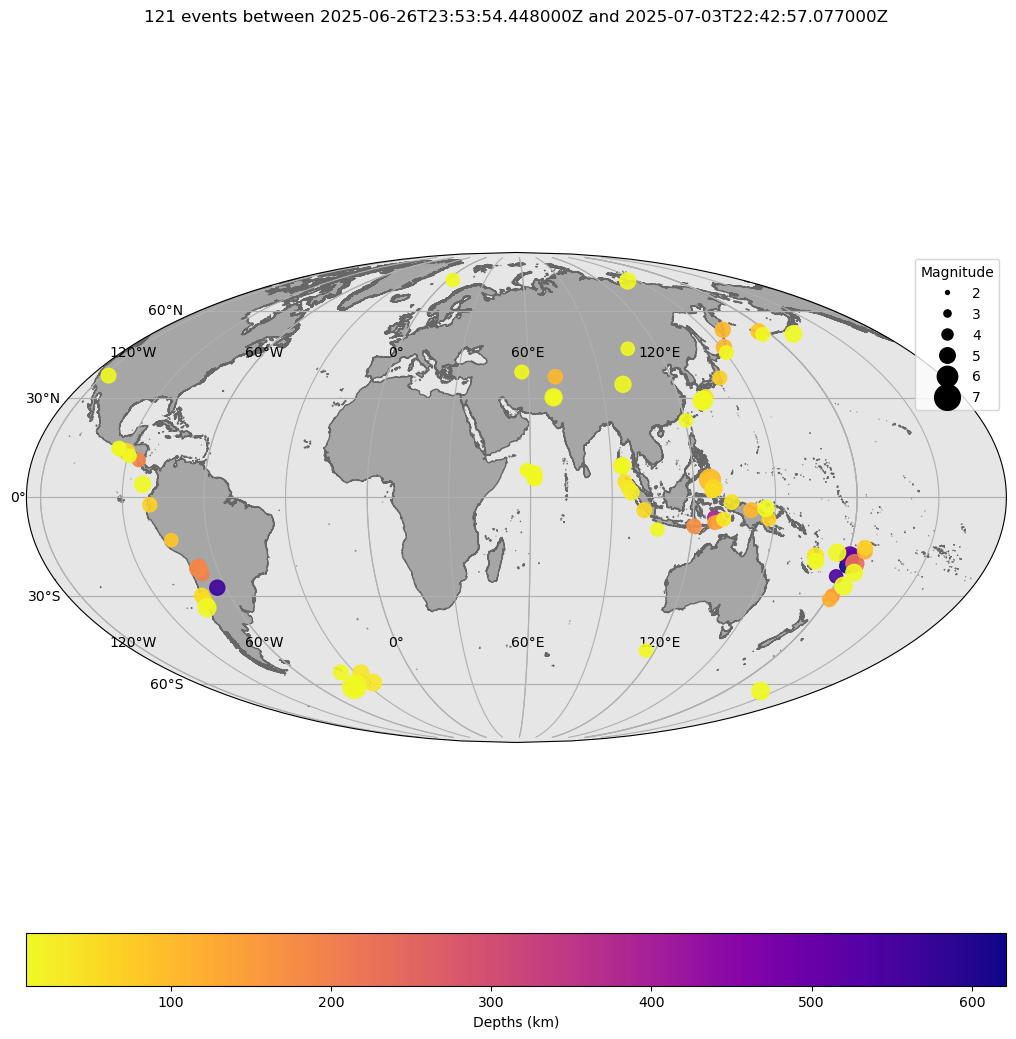

In [5]:
fig = plot_catalog(cat)
fig.savefig("Global_quakes.png")
fig.savefig("Global_quakes.svg")
mags = [eq.preferred_magnitude().mag for eq in cat]
print(f"Magnitudes between {min(mags)} and {max(mags)}")

## GeoNet earthquakes

I don't like the default sizing for catalog plotting, so I'm going to hack this a little...

In [6]:
client = Client("GEONET")
cat = client.get_events(starttime=UTCDateTime.now() - 7 * 86400)

Plotting in global
Magnitudes between 0.29813574040394286 and 6.103340213575389


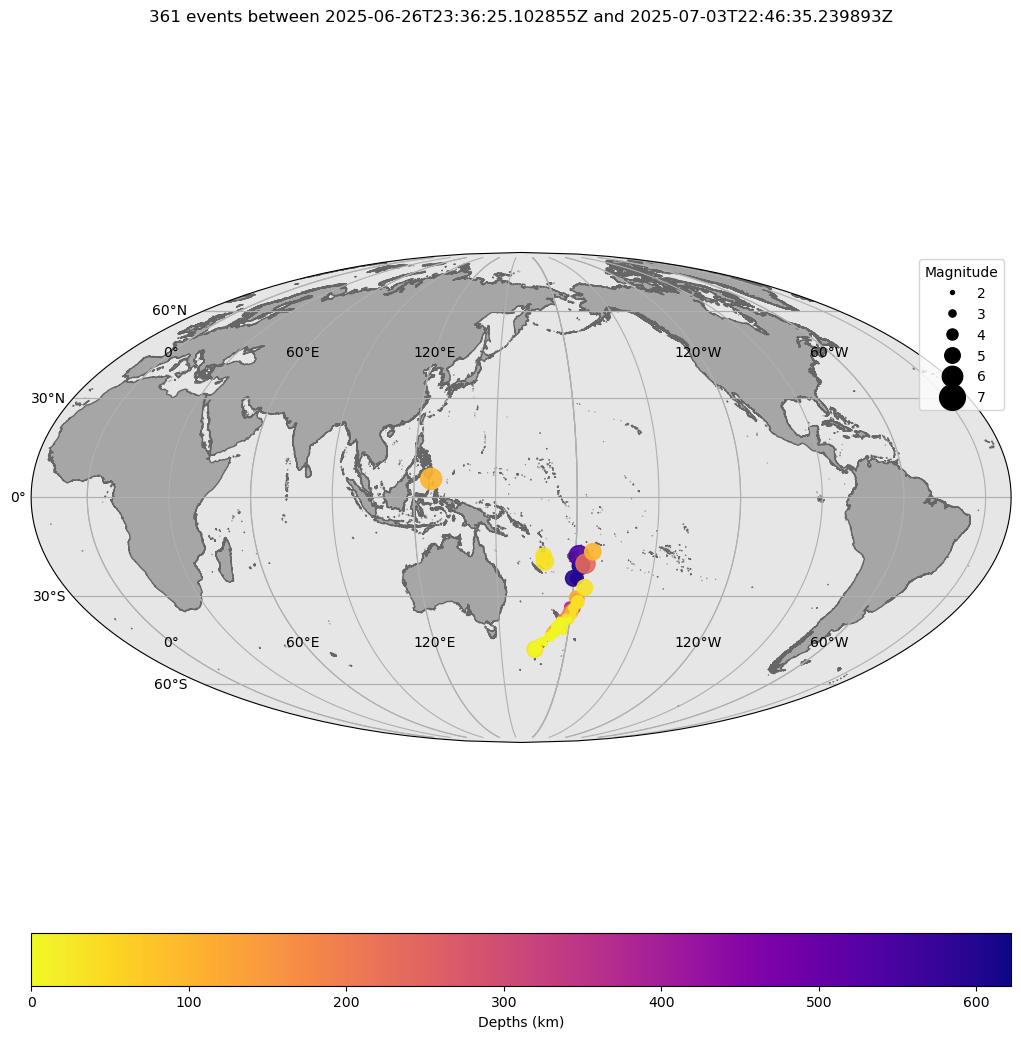

In [7]:
fig = plot_catalog(cat)
fig.savefig("GeoNet_quakes.png")
fig.savefig("GeoNet_quakes.svg")
mags = [eq.preferred_magnitude().mag for eq in cat]
print(f"Magnitudes between {min(mags)} and {max(mags)}")

If that looks ridiculous, we can just get earthquakes close to NZ:

In [8]:
cat = client.get_events(starttime=UTCDateTime.now() - 7 * 86400, maxlatitude=-35, minlatitude=-51, maxlongitude=180)

Plotting in local


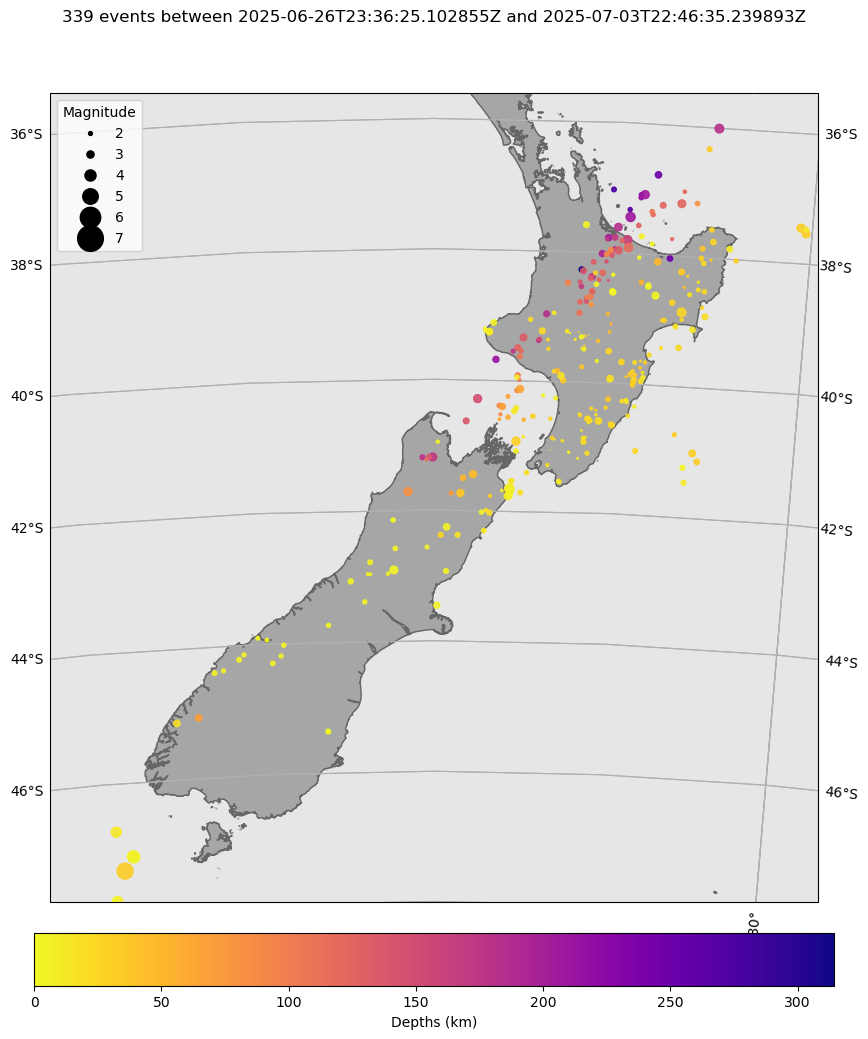

In [9]:
fig = plot_catalog(cat)
fig.savefig("NZ_quakes.png")
fig.savefig("NZ_quakes.svg")

In [10]:
mags = [eq.preferred_magnitude().mag for eq in cat]
print(f"Magnitudes between {min(mags)} and {max(mags)}")

Magnitudes between 0.29813574040394286 and 5.083006879672159
